## Курсовой проект от Мегафон

#### Задача: необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split

import itertools
import pickle

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
PATH_DATA = "../data"

In [3]:
data = pd.read_csv(os.path.join(PATH_DATA,'data_train.csv'))

In [4]:
data_test = pd.read_csv(os.path.join(PATH_DATA,'data_test.csv'))

In [5]:
features = pd.read_csv(os.path.join(PATH_DATA,'features.csv'), sep='\t')

In [6]:
df_f = features.copy()

In [7]:
# Добавим метку, что это не первое предложение клиенту
print(len(data), '+', len(data_test), '=', len(data) + len(data_test))
_df_concat = pd.concat([data, data_test], axis=0)
_df_concat['is_no_first'] = _df_concat.duplicated(subset='id', keep='first')*1
print('Проверка ', len(_df_concat))
data = _df_concat.iloc[:len(data),:]
data_test = _df_concat.iloc[:len(data_test),:]
print(len(data), '+', len(data_test), '=', len(data) + len(data_test))

831653 + 71231 = 902884
Проверка  902884
831653 + 71231 = 902884


In [8]:
from datetime import datetime
data['buy_time'] = [datetime.fromtimestamp(x) for x in data['buy_time']]
df_f['buy_time'] = [datetime.fromtimestamp(x) for x in df_f['buy_time']]
data_test['buy_time'] = [datetime.fromtimestamp(x) for x in data_test['buy_time']]

In [9]:
data = data.sort_values(by='buy_time')
df_f = df_f.sort_values(by='buy_time')
data_test = data_test.sort_values(by='buy_time')

In [10]:
df_f['buy_time_feat'] = df_f['buy_time']

In [11]:
df = pd.merge_asof(data, df_f, on="buy_time", by="id", direction='nearest')
df_test = pd.merge_asof(data_test, df_f, on="buy_time", by="id", direction='nearest')

In [12]:
df['diff'] = (df['buy_time'] - df['buy_time_feat']).dt.days
df_test['diff'] = (df_test['buy_time'] - df_test['buy_time_feat']).dt.days

In [13]:
df_test.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'buy_time_feat'], axis=1, inplace=True)

In [14]:
df_test['buy_time'] = [int(datetime.strptime(x, '%Y-%m-%d').strftime("%s")) for x in df_test['buy_time'].astype(str)]

In [139]:
# # Запускать вторым шагом после отбора фич для сокращения размера датасета
# df_test = df_test[['id', 'buy_time']+feature_cols]

In [142]:
# сохраним предобработанный файл с тестовыми данными
df_test.to_csv('../prediction/data_test_feat.csv')

In [143]:
df_test.head()

,id,buy_time,vas_id,is_no_first,diff,222,4,223,127,1,...,63,207,145,191,226,248,2,250,13,240
0,3044083,1531083600,5.0,0,-63,-5.726695e+08,33.681754,-58.544078,0.069549,250.130888,...,0.652424,-11953.712824,34.03637,-109.036398,-3.350668,-25.832889,39.099214,-12.175933,-66.189127,-512.437331
1,519581,1531083600,1.0,0,-154,-5.726695e+08,-101.998246,-58.544078,-0.060451,-394.699112,...,-0.237576,-11364.357024,-9.96363,-109.036398,5.649332,-25.832889,-96.580786,-12.175933,-66.189127,-512.437331
2,519230,1531083600,4.0,0,-168,9.732749e+08,1416.061754,449.925922,0.029549,292.720888,...,0.492424,203151.677176,19.03637,-109.036398,-14.931837,-10.832889,1417.239214,-11.175933,442.280873,3848.562669
3,2046295,1531083600,4.0,0,-154,9.721517e+08,284.271754,-48.794078,-0.050451,284.280888,...,-0.147576,-11953.712824,-6.96363,-109.036398,-13.376530,-25.832889,289.689214,-12.175933,-17.439127,-512.437331
4,2698338,1531083600,4.0,0,-70,9.646349e+08,168.581754,195.695922,0.109549,-52.279112,...,-0.237576,-11953.712824,21.03637,-109.036398,-5.350668,-19.832889,173.999214,-7.175933,-66.189127,-511.437331


### Бейзлайн

In [65]:
df_train = df.copy()

In [66]:
X_train = df_train[df_train['buy_time'] < '2018-11-30']
X_test = df_train[df_train['buy_time'] > '2018-11-30']
Y_train = X_train['target']
Y_test = X_test['target']

X_train.drop(['id', 'buy_time', 'target', 'Unnamed: 0_x', 'Unnamed: 0_y', 'buy_time_feat'], axis=1, inplace=True)
X_test.drop(['id', 'buy_time', 'target', 'Unnamed: 0_x', 'Unnamed: 0_y', 'buy_time_feat'], axis=1, inplace=True)

In [67]:
Y_test.to_csv("../prediction/Y_test.csv", index=False)

In [68]:
# X_train, X_test, Y_train, Y_test = train_test_split(df_train, TARGET_DATA, test_size=0.20, random_state=42, shuffle=False)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(584073, 256) (247580, 256) (584073,) (247580,)


In [21]:
# cat_feats = X_train.iloc[:, (X_train.nunique() < 10).values].columns.to_list()
# print(cat_feats)
# X_train[cat_feats] = X_train[cat_feats].astype('str')
# X_test[cat_feats] = X_test[cat_feats].astype('str')

In [124]:
# Запускать вторым шагом после отбора фич для сокращения размера датасета
# После первого прогона получили топ-20 фич. Оставляем только их для уменьшения размера датасета и заново запускаем и сохраняем модель.
# X_train = X_train[feature_cols]
# X_test = X_test[feature_cols]

In [125]:
train_data = Pool(data=X_train,
                   label=Y_train)
                   # cat_features=cat_feats)

eval_dataset = Pool(X_test,
                 label=Y_test)
                  # cat_features=cat_feats)

model = CatBoostClassifier(iterations=2500,
                           depth=10,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           eval_metric='AUC',
                           early_stopping_rounds=50,
                           grow_policy='Depthwise',
                           random_state=42,
                           thread_count=4,
                           use_best_model=True,
                           verbose=True)
# train the model
model.fit(train_data, eval_set=eval_dataset, logging_level='Silent')
# make the prediction using the resulting model
print(model.get_best_iteration())
preds_class = model.predict(train_data)
preds_proba = model.predict_proba(train_data)

10


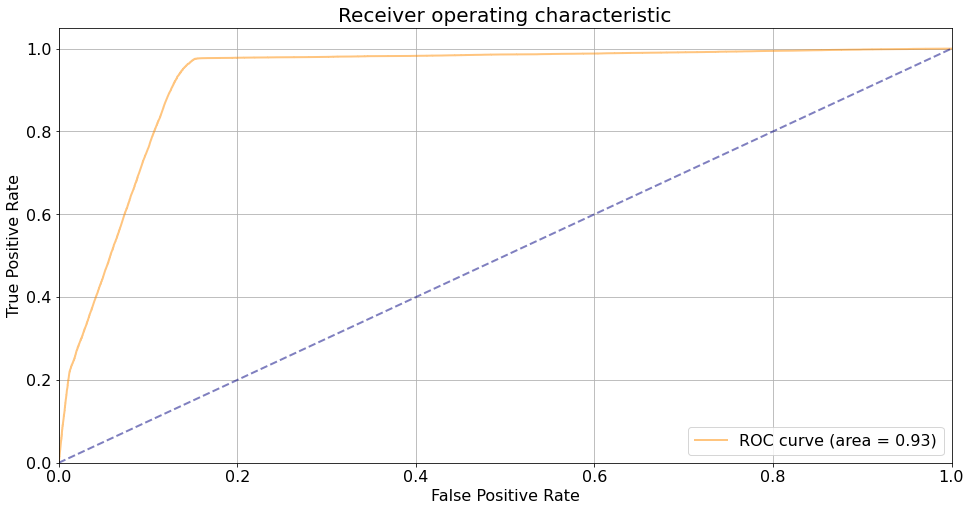

In [126]:
curve = get_roc_curve(model, eval_dataset)
(fpr, tpr, thresholds)=curve
roc_auc=auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

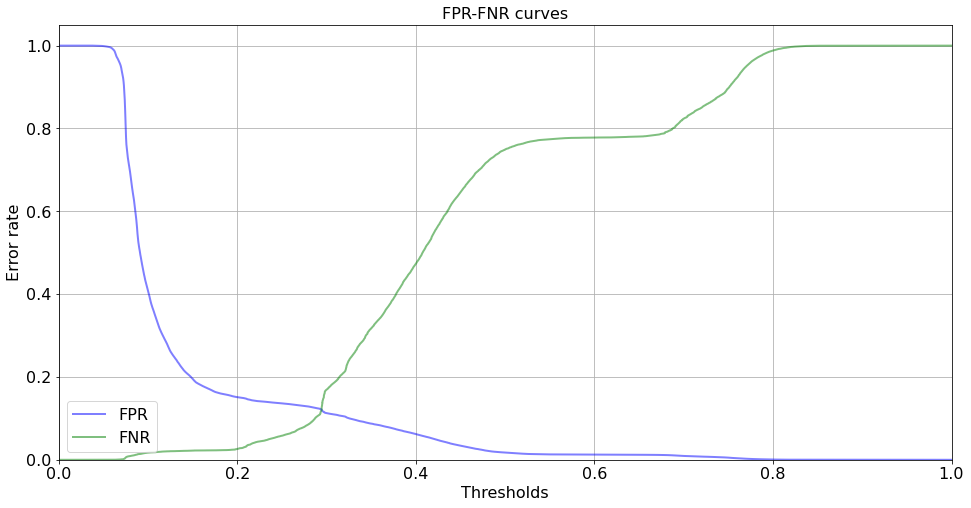

In [127]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [128]:
print(select_threshold(model=model, data=eval_dataset, FNR=0.01))
print(select_threshold(model=model, data=eval_dataset, FPR=0.01))

0.08206620332552583
0.6948402826041106


In [129]:
pkl_filename = "../prediction/pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [130]:
results = pd.DataFrame()
results['real'] = Y_train
results['catboost'] = preds_class

In [131]:
print(f"f1_score real: {f1_score(Y_train, results['real'], average='macro')}")
print(f"f1_score train: {f1_score(Y_train, results['catboost'], average='macro')}")
print(f"roc_auc_score train: {roc_auc_score(Y_train, preds_proba[:, 1])}")

f1_score real: 1.0
f1_score train: 0.7268146892245673
roc_auc_score train: 0.8935575713400297


In [132]:
preds_class = model.predict(eval_dataset)
preds_proba = model.predict_proba(eval_dataset)
results_test = pd.DataFrame()
results_test['real'] = Y_test
results_test['catboost'] = preds_class

In [133]:
print(f"f1_score real: {f1_score(Y_test, results_test['real'], average='macro')}")
print(f"f1_score test: {f1_score(Y_test, results_test['catboost'], average='macro')}")
print(f"roc_auc_score test: {roc_auc_score(Y_test, preds_proba[:, 1])}")

f1_score real: 1.0
f1_score test: 0.653447683838852
roc_auc_score test: 0.928549232157305


In [134]:
feature_importance = pd.DataFrame({'feature_importance': model.get_feature_importance(train_data),
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                                             ascending=False)

In [137]:
feature_importance

,feature_importance,feature_names
0,47.745388,vas_id
1,37.484506,is_no_first
2,9.808215,diff
3,0.682265,222
18,0.551280,4
5,0.498578,223
19,0.407261,127
15,0.384562,1
12,0.313357,14
4,0.287647,201


In [136]:
feature_cols = feature_importance[:20]['feature_names'].to_list()

In [161]:
preds = model.predict_proba(eval_dataset)[:, 1]
pd.DataFrame({'Preds': preds}).to_csv("../prediction/preds_test.csv", index=False)
precision, recall, thresholds = precision_recall_curve(Y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = 0
ix = np.argmax(fscore[:])
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.274741, F-Score=0.568, Precision=0.411, Recall=0.921


In [162]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[194668  30710]
 [  1289  20913]]


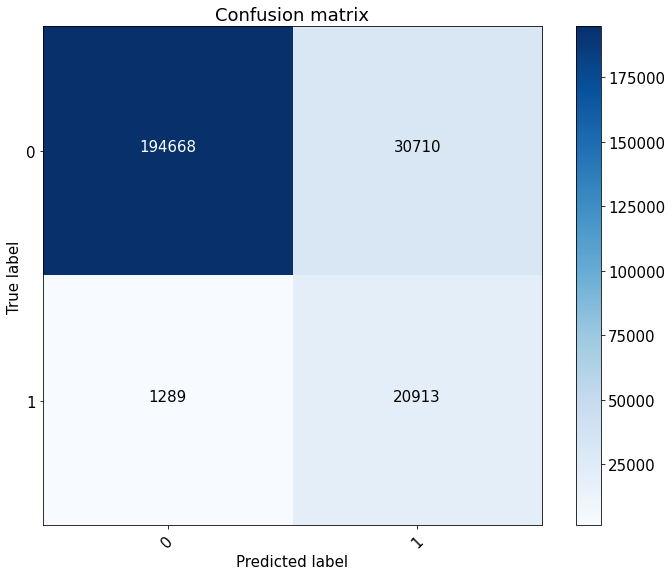

In [163]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(Y_test, preds>0.25)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], normalize=False,
                      title='Confusion matrix')
# plt.savefig("conf_matrix_expirience_del.png")
plt.show()

In [164]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.9419421673723088, 0.1362599721357009, 0.863740027864299)

In [166]:
def compare_threshold(single_client_revenue, per_client_costs):
    compare_thr = pd.DataFrame(columns=['Threshold', 'Recall', 'Zero_point', 'Formula', 'Profit'])
    for x in range(10, 90, 1):
        cnf_matrix = confusion_matrix(Y_test, preds>x/100)
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        TPR = round(TP/(TP+FN), 2)
        # FPR = FP/(FP+TN)
        # TNR = TN/(FP+TN)
        ALL = TP + FP

        zero_point = round((TP+FP)/TP, 2)
        formula = f'Profit = {TP} * SCR - {ALL} * PCC'

        # profit = ALL * single_client_revenue / zero_point - ALL * per_client_costs
        profit = TP * single_client_revenue - ALL * per_client_costs

        compare_thr = compare_thr.append({'Threshold': x/100, 'Recall': TPR, 'Zero_point': zero_point, 'Formula': formula, 'Profit': profit}, ignore_index=True)

    max_p = np.argmax(compare_thr['Profit'])

    max_profit = int(compare_thr['Profit'][max_p])
    best_threshold = compare_thr['Threshold'][max_p]
    recall = compare_thr['Recall'][max_p]

    return compare_thr, max_profit, best_threshold, recall

In [167]:
compare_thr, max_profit, best_threshold, recall = compare_threshold(5, 1)
print('max_profit: ', max_profit)
print('best_threshold: ', best_threshold)
print('recall: ', recall)
compare_thr

max_profit:  53061
best_threshold:  0.23
recall:  0.95


,Threshold,Recall,Zero_point,Formula,Profit
0,0.10,0.98,5.22,Profit = 21818 * SCR - 113868 * PCC,-4778
1,0.11,0.98,4.47,Profit = 21785 * SCR - 97424 * PCC,11501
2,0.12,0.98,3.96,Profit = 21752 * SCR - 86120 * PCC,22640
3,0.13,0.98,3.56,Profit = 21737 * SCR - 77282 * PCC,31403
4,0.14,0.98,3.25,Profit = 21722 * SCR - 70505 * PCC,38105
...,...,...,...,...,...
75,0.85,0.00,1.50,Profit = 6 * SCR - 9 * PCC,21
76,0.86,0.00,2.50,Profit = 2 * SCR - 5 * PCC,5
77,0.87,0.00,3.00,Profit = 1 * SCR - 3 * PCC,2
78,0.88,0.00,inf,Profit = 0 * SCR - 1 * PCC,-1


<AxesSubplot:xlabel='Полнота (доля правильно определенных пользователей, принявших предложение)', ylabel='Общая прибыль'>

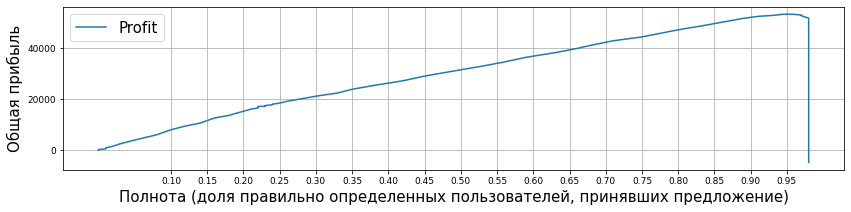

In [168]:
compare_thr.plot(x='Recall', y='Profit', figsize=(14,3), xticks=[x/100 for x in range(10,100,5)], xlabel='Полнота (доля правильно определенных пользователей, принявших предложение)', ylabel='Общая прибыль', grid=True, fontsize=9)

<AxesSubplot:xlabel='Threshold', ylabel='Общая прибыль'>

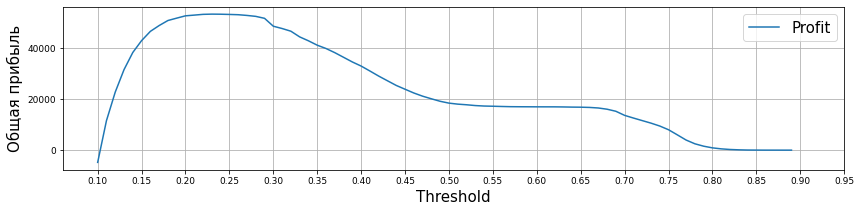

In [169]:
compare_thr.plot(x='Threshold', y='Profit', figsize=(14,3), xticks=[x/100 for x in range(10,100,5)], xlabel='Threshold', ylabel='Общая прибыль', grid=True, fontsize=9)

#### Беглый просмотр данных

In [101]:
df_train['month'] = [x[:7] for x in df_train['buy_time'].astype('str').to_list()]

In [107]:
df_train.groupby(['month'])['target'].agg(['sum', 'count', 'mean']).reset_index()

,month,sum,count,mean
0,2018-07,4660.0,136679,0.034094
1,2018-08,4118.0,146804,0.028051
2,2018-09,3414.0,112807,0.030264
3,2018-10,5308.0,114263,0.046454
4,2018-11,20484.0,73520,0.278618
5,2018-12,22202.0,247580,0.089676


<AxesSubplot:xlabel='month'>

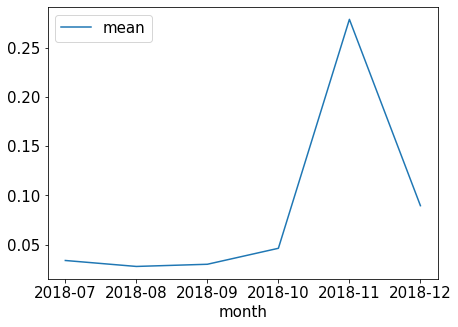

In [110]:
df_train.groupby(['month'])['target'].agg(['sum', 'count', 'mean']).reset_index().plot(x='month', y='mean', figsize=(7,5))

In [109]:
df_train.groupby(['vas_id'])['target'].agg(['sum', 'count', 'mean']).reset_index()

,vas_id,sum,count,mean
0,1.0,5664.0,310175,0.018261
1,2.0,4797.0,249505,0.019226
2,4.0,21765.0,85756,0.253801
3,5.0,1692.0,94085,0.017984
4,6.0,24704.0,57878,0.426829
5,7.0,213.0,15432,0.013802
6,8.0,347.0,13350,0.025993
7,9.0,1004.0,5472,0.183480


<AxesSubplot:xlabel='Услуга', ylabel='Процент подключений услуги'>

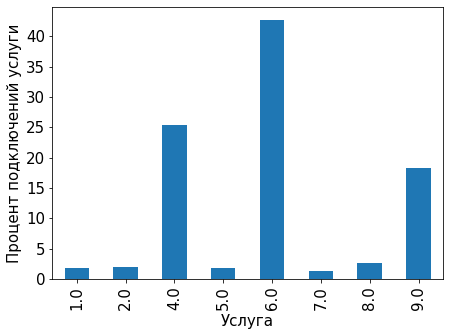

In [158]:
df_train.groupby(['vas_id'])['target'].apply(lambda x: x.mean()*100).plot(kind='bar', ylabel='Процент подключений услуги', xlabel='Услуга', figsize=(7,5))

<AxesSubplot:title={'center':'vas_id = 9'}, xlabel='buy_time'>

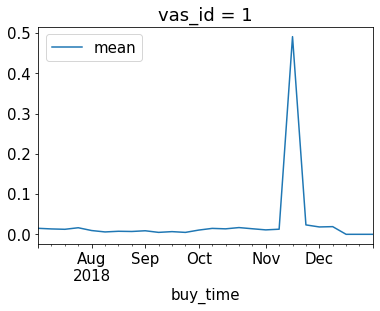

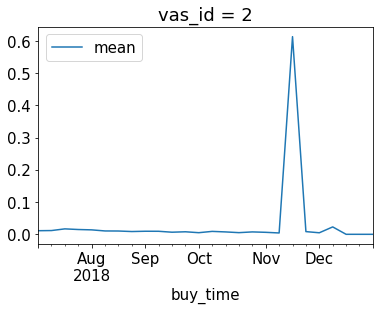

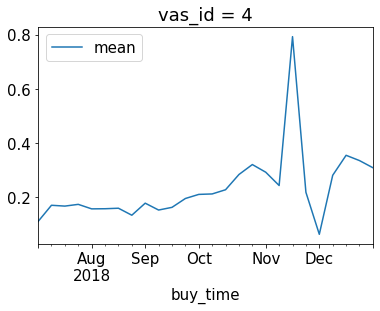

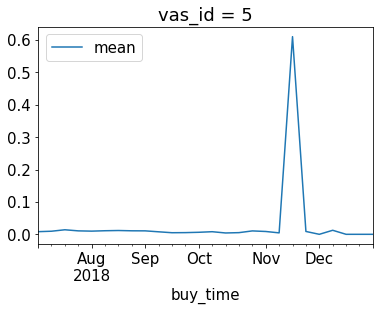

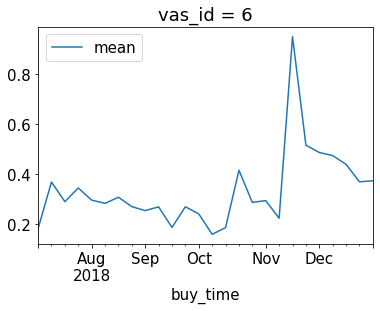

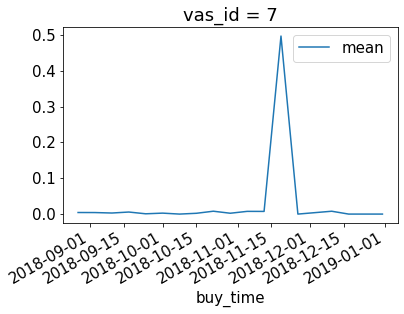

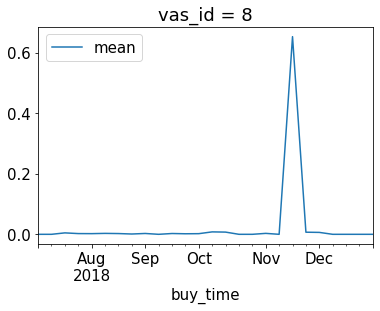

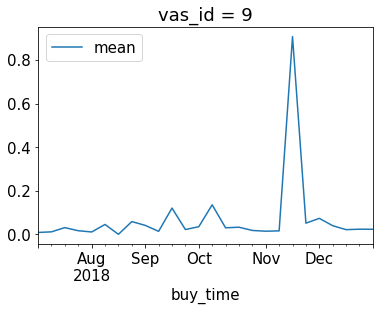

In [111]:
df_train[df_train['vas_id'] == 1].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 1')
df_train[df_train['vas_id'] == 2].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 2')
df_train[df_train['vas_id'] == 4].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 4')
df_train[df_train['vas_id'] == 5].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 5')
df_train[df_train['vas_id'] == 6].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 6')
df_train[df_train['vas_id'] == 7].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 7')
df_train[df_train['vas_id'] == 8].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 8')
df_train[df_train['vas_id'] == 9].groupby(['buy_time'])['target'].agg(['mean']).plot(title='vas_id = 9')

In [112]:
df_train.groupby(['month', 'vas_id'])['target'].agg(['sum', 'count', 'mean'])

sum   count      mean
month   vas_id                           
2018-07 1.0       755.0   57182  0.013203
        2.0       694.0   53202  0.013045
        4.0      2314.0   14431  0.160349
        5.0        79.0    6746  0.011711
        6.0       799.0    2579  0.309810
        8.0         7.0    1726  0.004056
        9.0        12.0     813  0.014760
2018-08 1.0       650.0   84291  0.007711
        2.0       281.0   26315  0.010678
        4.0      2307.0   15052  0.153269
        5.0       130.0   12002  0.010832
        6.0       716.0    2461  0.290939
        7.0         7.0    1596  0.004386
        8.0        10.0    4399  0.002273
        9.0        17.0     688  0.024709
2018-09 1.0       337.0   55243  0.006100
        2.0       196.0   23683  0.008276
        4.0      2289.0   13375  0.171140
        5.0        68.0    9759  0.006968
        6.0       477.0    1936  0.246384
        7.0        19.0    5513  0.003446
        8.0         5.0    2854  0.001752
        9.0        23.0     444  0.051802
2018-10 1.0       730.0   53159  0.013732
        2.0       197.0   29033  0.006785
        4.0      4141.0   16238  0.255019
        5.0        61.0    9112  0.006694
        6.0       128.0     547  0.234004
        7.0        10.0    3680  0.002717
        8.0         6.0    1899  0.003160
        9.0        35.0     595  0.058824
2018-11 1.0      3047.0   22618  0.134716
        2.0      2985.0   16976  0.175836
        4.0      8632.0   18774  0.459785
        5.0      1238.0    5951  0.208032
        6.0      3208.0    4936  0.649919
        7.0       172.0    1266  0.135861
        8.0       318.0    1303  0.244052
        9.0       884.0    1696  0.521226
2018-12 1.0       145.0   37682  0.003848
        2.0       444.0  100296  0.004427
        4.0      2082.0    7886  0.264012
        5.0       116.0   50515  0.002296
        6.0     19376.0   45419  0.426606
        7.0         5.0    3377  0.001481
        8.0         1.0    1169  0.000855
        9.0        33.0    1236  0.026699

In [113]:
df_train.groupby(['vas_id', 'buy_time'])['target'].agg(['sum', 'count', 'mean'])

sum  count      mean
vas_id buy_time                          
1.0    2018-07-09   66.0   4427  0.014909
       2018-07-16  106.0   7935  0.013359
       2018-07-23  480.0  38507  0.012465
       2018-07-30  103.0   6313  0.016316
       2018-08-06  278.0  29643  0.009378
...                  ...    ...       ...
9.0    2018-12-03    3.0     41  0.073171
       2018-12-10    7.0    177  0.039548
       2018-12-17    8.0    374  0.021390
       2018-12-24    7.0    298  0.023490
       2018-12-31    8.0    346  0.023121

[200 rows x 3 columns]

In [114]:
df_train[df_train['buy_time'] == '2018-11-19'].groupby(['vas_id', 'buy_time'])['target'].agg(['sum', 'count', 'mean'])

,,sum,count,mean
vas_id,buy_time,,,
1.0,2018-11-19,2824.0,5752,0.490960
2.0,2018-11-19,2913.0,4746,0.613780
4.0,2018-11-19,5640.0,7103,0.794031
5.0,2018-11-19,1210.0,1982,0.610494
6.0,2018-11-19,1484.0,1560,0.951282
7.0,2018-11-19,166.0,334,0.497006
8.0,2018-11-19,316.0,484,0.652893
9.0,2018-11-19,865.0,954,0.906709


In [115]:
df_train.groupby(['vas_id'])['id'].agg(['nunique', 'count'])

,nunique,count
vas_id,,
1.0,308736,310175
2.0,248826,249505
4.0,83178,85756
5.0,93417,94085
6.0,57163,57878
7.0,15415,15432
8.0,13248,13350
9.0,5421,5472
